<a href="https://colab.research.google.com/github/lonespear/MA206/blob/main/QuantitativeFinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantitative Finance: Time Series Modeling & Risk Analysis  

Finance is, at its core, about **making decisions under uncertainty**:  
- *Should I invest in stocks, bonds, or gold?*  
- *How do I balance risk against return?*  
- *What’s the chance of a major loss tomorrow?*  

These are not just questions for Wall Street — they are **applied math problems**.  
Quantitative finance brings together **probability, statistics, optimization, and computer modeling** to measure risk and guide decision-making in financial markets.

---

## What do we mean by *risky assets*?  
- A **risky asset** is any investment whose future value is uncertain: stocks, commodities, real estate, even currencies.  
- Unlike a **risk-free asset** (like a Treasury bond), risky assets have both upside (potential return) and downside (potential loss).  
- The challenge is not just predicting *returns*, but also quantifying the *risk* that comes with them.

---

## Why Time Series Modeling?  
Financial data are sequences through time — stock prices, interest rates, exchange rates.  
- We look for **patterns**: trends, cycles, volatility clustering.  
- We test models that can capture these dynamics and help us forecast or simulate what might come next.  

---

## Why It Matters  
Every major financial institution relies on these tools:  
- To manage portfolios worth billions,  
- To set aside capital against losses,  
- Design strategies that balance risk with reward.  


In [1]:
# Run these to install necessary dependencies
!pip install -q copulas yfinance arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 18.3 MB/s eta 0:00:00


In [7]:
# Load necessary dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import norm, t, gaussian_kde, genpareto
from scipy import stats
from sklearn.preprocessing import QuantileTransformer
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from copulas.multivariate import GaussianMultivariate
from ipywidgets import interact, Dropdown, FloatSlider, IntSlider

---

## From Risky Assets to Returns

Now that we’ve defined risky assets — investments whose future values are uncertain — the next question is:  
**How do we measure their performance mathematically?**

Prices alone don’t tell the story. A stock moving from \$50 → \$55 looks good, but how do we compare that to another stock moving from \$200 → \$210?  
We need a common unit of measurement: **returns**.

Returns capture the *percentage change* in value over time, and they are the basic building blocks of all portfolio theory, risk management, and forecasting.  
But not all return measures are created equal. That’s why we start with a comparison between **simple returns** and **logarithmic returns**, and why log returns have become the standard tool for modeling in quantitative finance.

---

### Why Use Log Returns Instead of Simple Returns?

A simple return is calculated as  

$$R_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$  

while the log return is  

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$  

Log returns are not perfect, but they offer key advantages:

- **Time Additivity**: They add neatly across periods, which makes modeling and compounding simpler.  
- **Symmetry**: They handle gains and losses more consistently.  
- **Closer to Normal**: Empirically, log returns tend to look more bell-shaped than simple returns, which makes them easier to plug into statistical and econometric models.  
- **Continuous Compounding**: They align with how growth processes are modeled in math and finance.  

---

#### Example: +10% followed by -10%

Suppose a stock price goes from \$100 → \$110 → \$99.

- **Simple Returns**  
  - Period 1: $ R_1 = \frac{110 - 100}{100} = 0.10 = 10\% $  
  - Period 2: $ R_2 = \frac{99 - 110}{110} = -0.10 = -10\% $  
  - Total: $(1+R_1)(1+R_2)-1 = (1.10)(0.90)-1 = -0.01 = -1\%$  

- **Log Returns**  
  - Period 1: $ r_1 = \ln\left(\frac{110}{100}\right) \approx 0.0953 $  
  - Period 2: $ r_2 = \ln\left(\frac{99}{110}\right) \approx -0.1001 $  
  - Total: $ r_1 + r_2 = -0.0048 $  
  - Which corresponds to $ e^{-0.0048} - 1 \approx -0.48\% $  

---

### But Are Returns Really Normal?  

Even though log returns are *closer* to normal, real financial data still show clear departures from the bell curve:  

- **Fat tails**: extreme moves happen far more often than a Gaussian model predicts.  
- **Skewness**: gains and losses aren’t perfectly symmetric.  
- **Volatility clustering**: quiet periods are followed by bursts of turbulence.  

This matters because risk models that assumed normality — for example, many banks before the **2008 financial crisis** — dramatically underestimated the frequency and severity of market crashes.  

To capture these realities, we often replace the Normal assumption with a **heavier-tailed distribution**, such as the **Student’s $t$-distribution**.

---

### 🔍 Fitting a $t$-distribution to Asset Returns

The Student’s $t$-distribution looks like a bell curve but with **fatter tails**.  
That means it predicts large shocks occur more often — much closer to what we see in real markets.  
It has one extra parameter, the **degrees of freedom ($\nu$)**, which controls how heavy the tails are.

The Probability Density Function of the $t$-distribution is:

$$
f(r) = \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\sqrt{\nu \pi} \, \Gamma\left(\frac{\nu}{2}\right)}
\left[1 + \frac{(r - \mu)^2}{\nu \sigma^2} \right]^{-\frac{\nu + 1}{2}}
$$

Let’s see this in action:


[*********************100%***********************]  1 of 1 completed


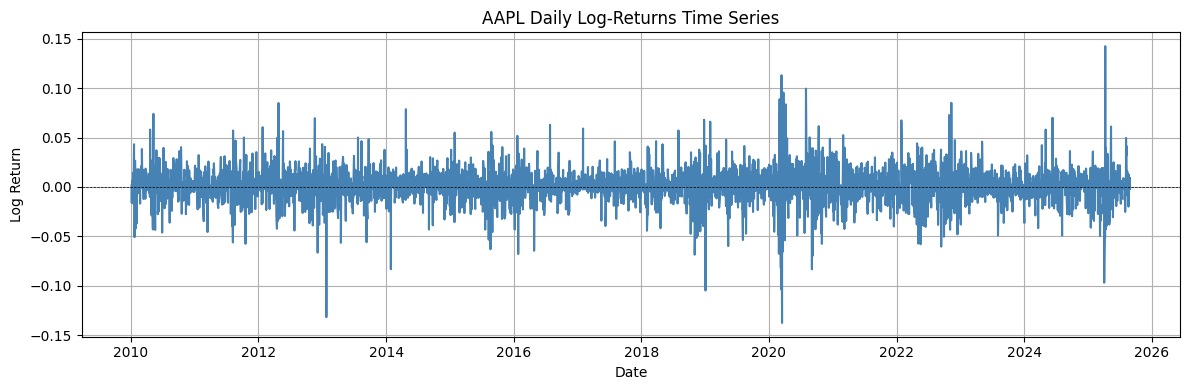

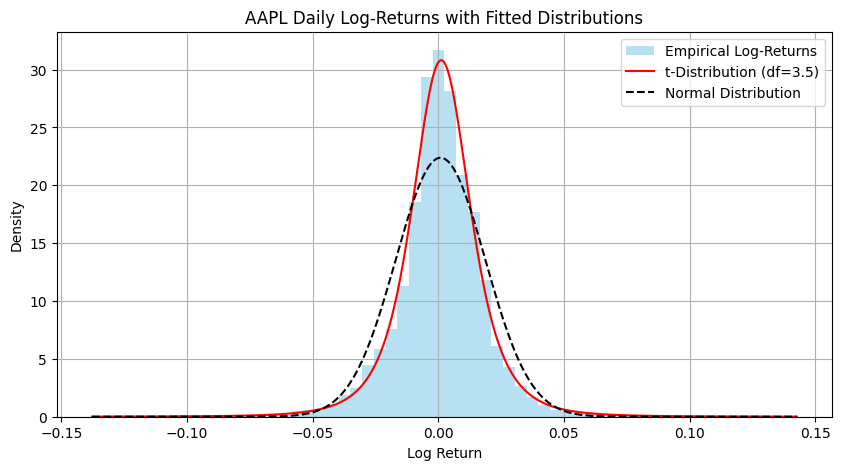

In [6]:
# Load historical daily price data
ticker = 'AAPL'
df = yf.download(ticker, start='2010-01-01', end='2025-09-02', auto_adjust=True)
prices = df['Close']
log_returns = np.log(prices / prices.shift(1)).dropna()

# Fit a t-distribution to log returns
params = t.fit(log_returns)  # returns df, loc, scale
df_t, mu_t, sigma_t = params

# Compare histogram to fitted t-distribution
x = np.linspace(log_returns.min(), log_returns.max(), 500)
pdf_t = t.pdf(x, df_t, loc=mu_t, scale=sigma_t)
pdf_n = norm.pdf(x, loc=log_returns.mean(), scale=log_returns.std())

# Plot time series of log-returns
plt.figure(figsize=(12, 4))
plt.plot(log_returns.index, log_returns, color='steelblue')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title(f"{ticker} Daily Log-Returns Time Series")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=60, density=True, alpha=0.6, color='skyblue', label='Empirical Log-Returns')
plt.plot(x, pdf_t, 'r-', label=f"t-Distribution (df={df_t:.1f})")
plt.plot(x, pdf_n, 'k--', label="Normal Distribution")
plt.title(f"{ticker} Daily Log-Returns with Fitted Distributions")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

> ⚠️ **IMPORTANT INFO**
>
> If there's one thing you should take away from this notebook, it's this:
>
> **Stock returns are *not* normally distributed.**
>
> Real-world returns often exhibit **fat tails**, **skewness**, and **volatility clustering** — all of which violate the assumptions of normality.  
>  
> That’s why we fit a **t-distribution** here: it allows for heavier tails, better reflecting the risks involved in financial markets.
>
>[If you still don't believe me, learn why 2008 happened.](https://www.wired.com/2009/02/wp-quant/)

---

## 🌋 Extreme Risk: Peaks Over Threshold & Bootstrapping Coverage

So far we’ve seen that returns are not perfectly normal — they have **fat tails** and large shocks happen more often than the bell curve suggests.  
How can we **measure and stress-test those extreme risks**?

Two powerful tools used in quantitative finance are:

- **Peaks Over Threshold (POT)** from *Extreme Value Theory*  
- **Bootstrapping coverage** for risk estimates  

---

### Peaks Over Threshold (POT)

Instead of modeling the entire return distribution, POT focuses only on the **extreme tail**.  

Steps:
1. Choose a high threshold (e.g., losses worse than the 95th percentile).  
2. Collect all returns beyond that threshold.  
3. Fit a **Generalized Pareto Distribution (GPD)** to just those extreme values.  

👉 This gives a sharper estimate of **Value-at-Risk (VaR)** and **Expected Shortfall (ES)** for rare market events.

---

### Bootstrapping Coverage

Even if we compute VaR and ES, how confident are we in those numbers?  
With limited data, our risk estimates can vary a lot.

**Bootstrapping** solves this by:
- Resampling the return series many times,  
- Recalculating VaR/ES each time,  
- Building a distribution of estimates.  

👉 This gives us **confidence intervals** for VaR/ES — how stable our risk measures really are.

---

### ⚠️ Why It Matters

- **POT** shows us that single assets can have much nastier tails than the Normal model predicts.  
- **Bootstrapping** shows us that even our tail estimates are uncertain.  

This motivates **Modern Portfolio Theory (MPT)**:  
instead of trying to tame the risk of one asset, we diversify intelligently across many.

---


POT 95% VaR ≈ -0.0279
POT 95% ES  ≈ -0.0356
Bootstrap 95% VaR CI: [-0.0300, -0.0253]
Bootstrap 95% ES  CI: [-0.0473, -0.0368]


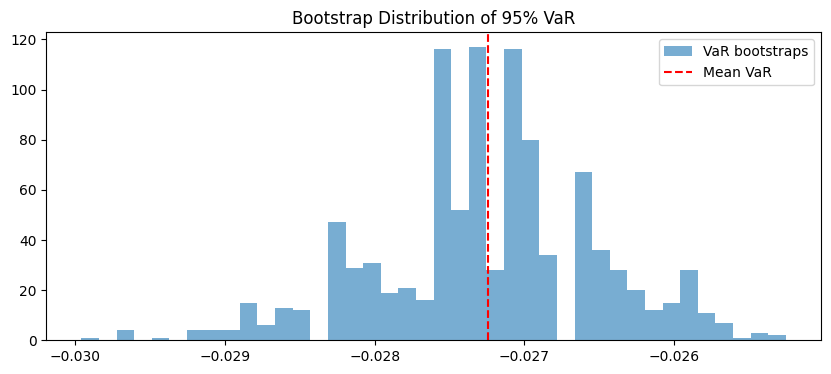

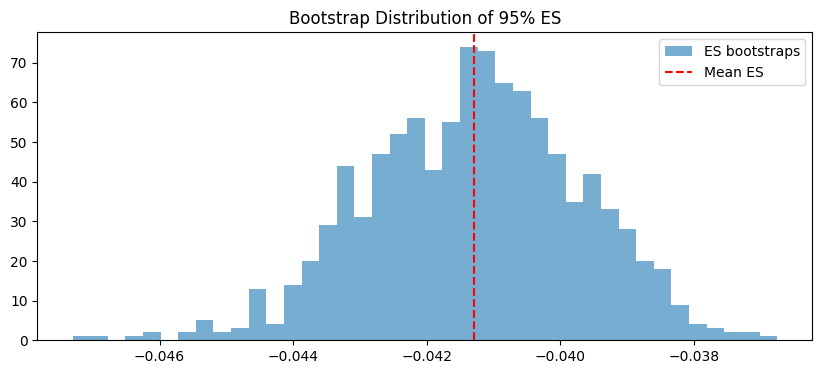

In [15]:
alpha = 0.05  # 95% confidence
threshold = np.percentile(log_returns, 100 * alpha)

# --- Peaks Over Threshold (POT) fit ---
exceedances = (log_returns[log_returns < threshold] - threshold).values
exceedances = exceedances[np.isfinite(exceedances)]
c, loc, scale = genpareto.fit(-exceedances)  # fit GPD to negative tail

# Estimate VaR and ES from POT
VaR_pot = threshold - genpareto.ppf(alpha, c, loc=loc, scale=scale)
ES_pot = threshold - (scale + c*threshold)/(1-c) if c < 1 else np.nan

print(f"POT 95% VaR ≈ {VaR_pot:.4f}")
print(f"POT 95% ES  ≈ {ES_pot:.4f}")

# --- Bootstrapping Coverage ---
n_boot = 1000
returns_array = log_returns.values.flatten()

VaR_boot, ES_boot = [], []

for _ in range(n_boot):
    sample = np.random.choice(returns_array, size=len(returns_array), replace=True)
    q = np.percentile(sample, 100*alpha)
    VaR_boot.append(q)
    ES_boot.append(sample[sample <= q].mean())
VaR_boot = np.array(VaR_boot)
ES_boot = np.array(ES_boot)

print(f"Bootstrap 95% VaR CI: [{VaR_boot.min():.4f}, {VaR_boot.max():.4f}]")
print(f"Bootstrap 95% ES  CI: [{ES_boot.min():.4f}, {ES_boot.max():.4f}]")

# --- Plot bootstrap distributions ---
plt.figure(figsize=(10,4))
plt.hist(VaR_boot, bins=40, alpha=0.6, label="VaR bootstraps")
plt.axvline(np.mean(VaR_boot), color="red", linestyle="--", label="Mean VaR")
plt.title("Bootstrap Distribution of 95% VaR")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(ES_boot, bins=40, alpha=0.6, label="ES bootstraps")
plt.axvline(np.mean(ES_boot), color="red", linestyle="--", label="Mean ES")
plt.title("Bootstrap Distribution of 95% ES")
plt.legend()
plt.show()

---

Up to this point, we’ve seen the **ugly side of risky assets**. Individual stocks can have fat-tailed shocks, volatility clustering, and losses far worse than a simple normal model would predict. Using POT and bootstrapping, we saw that extreme events are not only more likely than expected, but even our *estimates* of that risk are uncertain.

So the question is:  
**If single risky assets are this unpredictable, how can we still seek returns while protecting ourselves from the downside?**

This is where **diversification** comes in. By combining assets with different risks and correlations, the overall portfolio can actually be **less risky** than any single component. That insight leads us to **Modern Portfolio Theory (MPT)**.

---

# 📊 Modern Portfolio Theory (MPT)

MPT, developed by Harry Markowitz in the 1950s, provides a mathematical framework for constructing portfolios that **maximize expected return for a given level of risk**. It introduced the key concepts of the **Efficient Frontier**, **Capital Market Line (CML)**, and **Sharpe Ratio**.

> 🎥 *Recommended video:*  
> ["Modern Portfolio Theory Explained"](https://www.youtube.com/watch?v=rn8aL9iFMRs) *(Ben Felix, 10 mins)*

![MPT](https://raw.githubusercontent.com/lonespear/MA206/main/mpt.jpg)  
*Source: yourwealth.com*

---

## 💼 Why Optimize a Portfolio?

Suppose you’re building a long-term investment portfolio — maybe stocks, bonds, gold, and real estate. Should you:

- Just pick the top performers from last year?  
- Spread funds equally across assets?  
- Favor the assets with the highest return?  

Intuition tells us that **risk differs by asset** and that combining them can smooth volatility. MPT turns that intuition into math, showing that *diversification* produces portfolios that achieve **higher returns for the same risk, or lower risk for the same return**.

---

## 🔢 Mathematical Foundation

Let:  
- $\vec{w}$ = portfolio weights  
- $\vec{\mu}$ = expected asset returns  
- $\Sigma$ = covariance matrix of returns  
- $r_f$ = risk-free rate  

Then:  
- Portfolio return: $\mu_p = \vec{w}^\top \vec{\mu}$  
- Portfolio variance: $\sigma_p^2 = \vec{w}^\top \Sigma \vec{w}$  
- Sharpe ratio: $SR = \frac{\mu_p - r_f}{\sigma_p}$  

---

## ⚙️ Quadratic Programming and the Efficient Frontier

Constructing the efficient frontier is a **quadratic optimization problem**:

\begin{aligned}
\text{Minimize: } & \quad \tfrac{1}{2} \vec{w}^\top \Sigma \vec{w} \\
\text{Subject to: } & \quad \vec{w}^\top \vec{\mu} = R_{\text{target}} \\
& \quad \sum w_i = 1 \\
& \quad w_i \geq 0 \quad \text{(optional, no short-selling)}
\end{aligned}

- Objective = quadratic (portfolio variance).  
- Constraints = linear (budget, target return).  

Solve this for many values of $R_{\text{target}}$ → you trace out the **Efficient Frontier**.  
- The **global minimum variance portfolio** = lowest point.  
- The **tangency portfolio** = maximizes the Sharpe ratio, giving the **Capital Market Line**.

---

**Bottom line:**  
MPT reduces portfolio construction to a clean optimization problem — transforming the messy reality of risky assets into rigorous, solvable math.

---

Next, we’ll bring MPT to life by downloading historical data, computing returns and covariances, and solving for optimal portfolios.


In [70]:
def run_mpt_analysis(tickers, period="10y", rf=0.02, allow_short=False):
    """Run MPT optimization and plot Efficient Frontier with GMV and Tangency portfolios."""

    # -----------------------
    # Data prep
    # -----------------------
    px = yf.download(tickers, period=period, auto_adjust=True, progress=False)["Close"]
    rets = np.log(px / px.shift(1)).dropna()

    # Keep alignment consistent
    assets = rets.columns
    mu = rets.mean().loc[assets].values * 252
    Sigma = rets.cov().loc[assets, assets].values * 252

    # -----------------------
    # Helper functions
    # -----------------------
    def portfolio_stats(w):
        r = float(w @ mu)
        v = float(np.sqrt(w @ Sigma @ w))
        return r, v, (r - rf) / v

    def weight_constraints(n):
        cons = ({'type': 'eq', 'fun': lambda w: np.sum(np.abs(w)) - 1.0},)
        if allow_short:
            cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)
            bounds = tuple((-1.0, 1.0) for _ in range(n))
        else:
            bounds = tuple((0.0, 1.0) for _ in range(n))
        return cons, bounds

    def min_var_for_target_return(target_r):
        cons, bounds = weight_constraints(len(mu))
        cons = cons + ({'type': 'eq', 'fun': lambda w, tr=target_r: w @ mu - tr},)
        w0 = np.ones(len(mu)) / len(mu)
        res = minimize(lambda w: w @ Sigma @ w, w0,
                       method='SLSQP', bounds=bounds, constraints=cons)
        return res.x

    def global_min_var():
        cons, bounds = weight_constraints(len(mu))
        w0 = np.ones(len(mu)) / len(mu)
        res = minimize(lambda w: w @ Sigma @ w, w0,
                       method='SLSQP', bounds=bounds, constraints=cons)
        return res.x

    def tangency_portfolio():
        def neg_sharpe(w):
            r, v, _ = portfolio_stats(w)
            return -(r - rf) / v
        cons, bounds = weight_constraints(len(mu))
        w0 = np.ones(len(mu)) / len(mu)
        res = minimize(neg_sharpe, w0,
                       method='SLSQP', bounds=bounds, constraints=cons)
        return res.x

    # -----------------------
    # Solve portfolios
    # -----------------------
    w_gmv = global_min_var()
    r_gmv, v_gmv, _ = portfolio_stats(w_gmv)

    r_min, r_max = r_gmv, max(mu)
    targets = np.linspace(r_min, r_max, 60)

    frontier = []
    for tr in targets:
        try:
            w = min_var_for_target_return(tr)
            r, v, _ = portfolio_stats(w)
            frontier.append((r, v))
        except Exception:
            pass

    frontier = np.array(frontier)

    w_tan = tangency_portfolio()
    r_tan, v_tan, s_tan = portfolio_stats(w_tan)

    v_line = np.linspace(0, frontier[:, 1].max(), 50)
    r_line = rf + s_tan * v_line

    # -----------------------
    # Plot
    # -----------------------
    fig, ax = plt.subplots(figsize=(8, 5.5))
    ax.plot(frontier[:, 1], frontier[:, 0], lw=2, label="Efficient Frontier")

    asset_vols = np.sqrt(np.diag(Sigma))
    ax.scatter(asset_vols, mu, s=60, marker='o', label="Assets")
    for i, t in enumerate(assets):
        ax.annotate(t, (asset_vols[i], mu[i]), xytext=(5, 5), textcoords='offset points')

    ax.scatter(v_gmv, r_gmv, s=80, marker='D', label="Global Min-Var")
    ax.scatter(v_tan, r_tan, s=90, marker='*', label=f"Tangency (Sharpe={s_tan:.2f})")
    ax.plot(v_line, r_line, ls='--', label="Capital Market Line")

    ax.set_xlabel("Volatility (σ, annualized)")
    ax.set_ylabel("Return (μ, annualized)")
    ax.set_title("Efficient Frontier with GMV and Tangency Portfolio")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.show()

    # -----------------------
    # Display summaries
    # -----------------------
    pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

    print("Tangency Portfolio (Top 10 holdings by magnitude):")
    tan_wt = pd.Series(w_tan, index=assets)
    tan_top10 = tan_wt.reindex(tan_wt.abs().sort_values(ascending=False).index).head(10)
    display(tan_top10)
    print(f"  Return:     {r_tan:.3f}")
    print(f"  Volatility: {v_tan:.3f}")
    print(f"  Sharpe:     {s_tan:.2f}\n")

    print("Global Minimum Variance Portfolio (Top 10 holdings by magnitude):")
    gmv_wt = pd.Series(w_gmv, index=assets)
    gmv_top10 = gmv_wt.reindex(gmv_wt.abs().sort_values(ascending=False).index).head(10)
    display(gmv_top10)
    print(f"  Return:     {r_gmv:.3f}")
    print(f"  Volatility: {v_gmv:.3f}")

    return {
        "rets": rets,
        "tangency": {"weights": w_tan, "mu": mu, "Sigma": Sigma},
        "gmv": {"weights": w_gmv, "mu": mu, "Sigma": Sigma}
    }

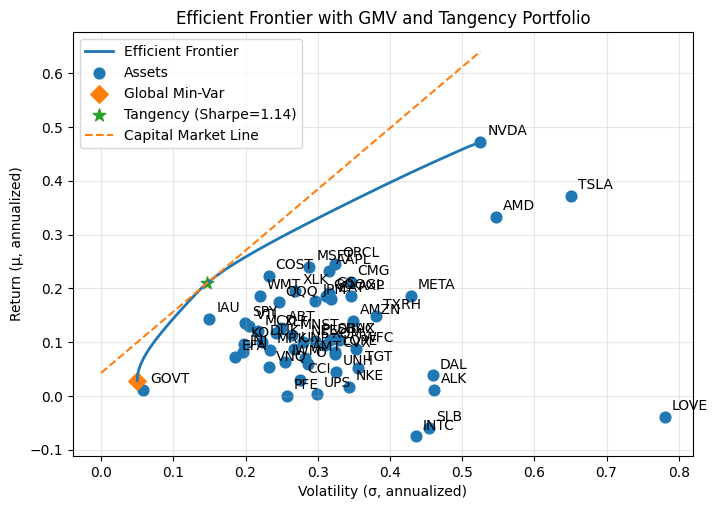

Tangency Portfolio (Top 10 holdings by magnitude):


,0
Ticker,
IAU,0.497
COST,0.149
WMT,0.138
NVDA,0.119
ORCL,0.049
JPM,0.034
TSLA,0.014
CAT,0.000
MRK,0.000


  Return:     0.209
  Volatility: 0.146
  Sharpe:     1.14

Global Minimum Variance Portfolio (Top 10 holdings by magnitude):


,0
Ticker,
GOVT,0.858
JPM,0.031
WMT,0.027
JNJ,0.021
XOM,0.021
MRK,0.012
CAT,0.011
WFC,0.008
UNH,0.007


  Return:     0.029
  Volatility: 0.050


In [71]:
# ---- choose tickers (feel free to swap/extend) ----
portfolio_1 = [
    # --- Core ETFs ---
    "SPY", "QQQ", "IAU", "GOVT", "VNQ", "VTI", "EFA", "IWM", "XLK", "XLF",

    # --- Tech ---
    "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "TSLA", "META", "ORCL", "INTC", "AMD",

    # --- Consumer / Retail ---
    "CMG", "MCD", "SBUX", "TGT", "WMT", "COST", "NKE", "MNST", "KO", "TXRH",

    # --- Industrials / Transportation ---
    "ALK", "DAL", "UPS", "UNP", "CAT", "LOVE",

    # --- Healthcare / Pharma ---
    "JNJ", "PFE", "MRK", "UNH", "ABT",

    # --- Financials ---
    "JPM", "GS", "BAC", "WFC", "AXP",

    # --- Energy / Utilities ---
    "XOM", "CVX", "SLB", "NEE", "DUK",

    # --- REITs / Real Assets ---
    "LOPE", "O", "PLD", "AMT", "CCI"
]
portfolio_2 = ["SPY", "QQQ", "IAU", "GOVT", "VNQ", "VTI"]
results = run_mpt_analysis(portfolio_1, rf=0.043, allow_short=False)

rets = results["rets"]

w_tan = results["tangency"]["weights"]
mu = results["tangency"]["mu"]
Sigma = results["tangency"]["Sigma"]

mu_tan = w_tan @ mu
sigma_tan = np.sqrt(w_tan @ Sigma @ w_tan)
sr_tan = (mu_tan - 0.043) / sigma_tan

---

### 🧾 Tangency Portfolio Results Summary

The **Tangency Portfolio**, shown as a green star on the Efficient Frontier plot, is the unique portfolio that:

- Maximizes the **Sharpe Ratio**:
  $$
  SR = \frac{\mu_p - r_f}{\sigma_p}
  $$

- Lies at the tangency point between the **Efficient Frontier** and the **Capital Market Line (CML)**:
  $$
  \mu_p = r_f + \frac{\mu_m - r_f}{\sigma_m} \cdot \sigma_p
  $$

Key characteristics:

- **Expected Annual Return**:
  $$
  \mu_{\text{tan}} = \vec{w}_{\text{tan}}^\top \vec{\mu}
  $$

- **Portfolio Volatility**:
  $$
  \sigma_{\text{tan}} = \sqrt{\vec{w}_{\text{tan}}^\top \Sigma \vec{w}_{\text{tan}}}
  $$

- **Sharpe Ratio**:
  $$
  SR = \frac{\mu_{\text{tan}} - r_f}{\sigma_{\text{tan}}}
  $$

Use the code cell below to compute these values in Python:

In [72]:
mu_tan = w_tan @ mu
sigma_tan = np.sqrt(w_tan @ Sigma @ w_tan)
sr_tan = (mu_tan - 0.043) / sigma_tan

print(f"Expected Annual Return (μ): {mu_tan:.3f}")
print(f"Volatility (σ): {sigma_tan:.3f}")
print(f"Sharpe Ratio: {sr_tan:.2f}")

Expected Annual Return (μ): 0.209
Volatility (σ): 0.146
Sharpe Ratio: 1.14


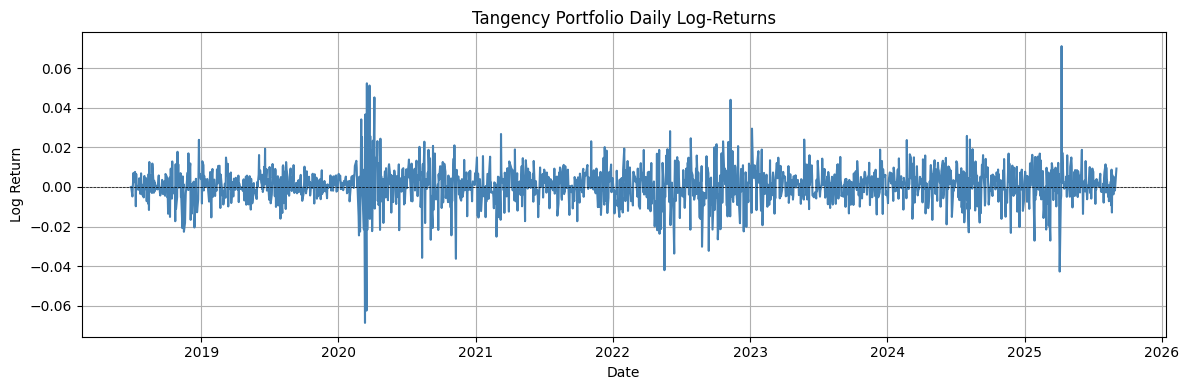

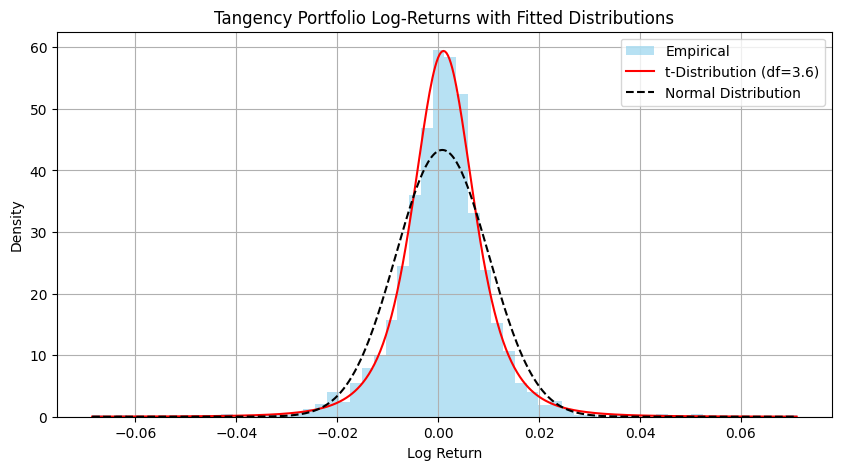

In [83]:
from scipy.stats import norm, t, gaussian_kde, genpareto
# Tangency portfolio daily returns (already log returns)
log_returns = (rets @ w_tan).dropna()

# Fit a Student-t distribution
df_t, mu_t, sigma_t = t.fit(log_returns)

# Compare fitted t vs normal
x = np.linspace(log_returns.min(), log_returns.max(), 500)
pdf_t = t.pdf(x, df_t, loc=mu_t, scale=sigma_t)
pdf_n = norm.pdf(x, loc=log_returns.mean(), scale=log_returns.std())

# Time series
plt.figure(figsize=(12, 4))
plt.plot(log_returns.index, log_returns, color='steelblue')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title("Tangency Portfolio Daily Log-Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram vs fitted distributions
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=60, density=True, alpha=0.6, color='skyblue', label='Empirical')
plt.plot(x, pdf_t, 'r-', label=f"t-Distribution (df={df_t:.1f})")
plt.plot(x, pdf_n, 'k--', label="Normal Distribution")
plt.title("Tangency Portfolio Log-Returns with Fitted Distributions")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

Now that we see what modeling a portfolio is like just using long positions, enable short trades by changing the `allow_short` to `True` and note the change in the Sharpe Ratio. Do you think implementing this strategy is realistic? What may be some overlooked aspects of this model?

---

## 📉 Understanding Volatility and Risk Measures

Once we've defined the **expected return** of a portfolio, the natural next question is:  
> _How risky is this return?_  

This is where **volatility** comes in.

### 🔁 Volatility as a Measure of Risk

Volatility is typically measured as the **standard deviation** of portfolio returns:
$$
\sigma_p = \sqrt{\mathbf{w}^T \Sigma \mathbf{w}}
$$
where:
- $\mathbf{w}$ is the vector of portfolio weights  
- $\Sigma$ is the covariance matrix of asset returns  
- $\sigma_p$ is the total **portfolio volatility**

More fundamentally, the **variance** of the portfolio is:
$$
\text{Var}(r_p) = \mathbf{w}^T \Sigma \mathbf{w}
$$

So, volatility captures the **dispersion** of returns — how much returns are likely to deviate from the expected mean.

> A portfolio with high volatility is considered riskier because its returns are more unpredictable.

---

### 🧠 But Is Volatility Enough?

While volatility is useful, it's **symmetric** — it treats upside and downside deviations equally.

In practice, investors are much more concerned with **downside risk**:
- What if my portfolio drops by 10% tomorrow?
- How bad could losses get in a crisis?

This motivates **tail risk measures** like:

### ⚠️ Value at Risk (VaR)

Value at Risk at level $\alpha$ answers:

> What is the worst expected loss over a given time period with probability $1 - \alpha$?

Mathematically (assuming normal returns):
$$
\text{VaR}_\alpha = \mu_p + \sigma_p \cdot \Phi^{-1}(\alpha)
$$
where:
- $\mu_p$ is the portfolio expected return
- $\sigma_p$ is the portfolio standard deviation
- $\Phi^{-1}(\alpha)$ is the inverse standard normal CDF at level $\alpha$

Example:  
If $\text{VaR}_{0.05} = -0.10$, there's a 5% chance your portfolio will lose **more than 10%** in the given time horizon.

---

### 🩸 Expected Shortfall (ES or CVaR)

Expected Shortfall at level $\alpha$ asks:

> If things do go bad (i.e., in the worst $\alpha\%$ of cases), **how bad on average** are the losses?

For normal distributions:
$$
\text{ES}_\alpha = \mu_p + \sigma_p \cdot \frac{\phi(\Phi^{-1}(\alpha))}{\alpha}
$$
where $\phi$ is the standard normal PDF.

Unlike VaR, **ES captures the full tail** of the loss distribution and is a coherent risk measure.

---

### 🧭 Summary

| Concept              | Captures                        | Symmetric? | Good for |
|----------------------|----------------------------------|------------|-----------|
| **Volatility**       | Return variability              | ✅ Yes     | General risk, optimization |
| **VaR**              | Worst-case threshold loss       | ❌ No      | Risk limits, compliance   |
| **Expected Shortfall (ES)** | Average of worst-case losses | ❌ No      | Tail-risk, capital reserves |

Together, these measures give a **holistic picture of portfolio risk** beyond just standard deviation.


In [89]:
from scipy.stats import norm, t
import numpy as np
import pandas as pd

alpha = 0.01  # Change this based on how extreme you want your losses to be

# Fit distributions once
mu_n, sigma_n = log_returns.mean(), log_returns.std()
df_t, mu_t, sigma_t = t.fit(log_returns)

# Helper to compute everything
def var_es_comparison(log_returns, horizon):
    """
    Compute VaR and ES for empirical, normal, and t-distribution
    at a given horizon (days).
    """
    # Scale factor for parametric models
    scale = np.sqrt(horizon)

    # --- Empirical (bootstrap / scaling approximation) ---
    # For simplicity: scale daily empirical VaR/ES by √T
    VaR_emp_1d = np.percentile(log_returns, 100*alpha)
    ES_emp_1d = log_returns[log_returns <= VaR_emp_1d].mean()
    VaR_emp = VaR_emp_1d * scale
    ES_emp = ES_emp_1d * scale

    # --- Normal parametric ---
    VaR_norm = norm.ppf(alpha, loc=mu_n*horizon, scale=sigma_n*scale)
    ES_norm = mu_n*horizon - sigma_n*scale * norm.pdf(norm.ppf(alpha)) / alpha

    # --- Student-t parametric ---
    VaR_t = t.ppf(alpha, df_t, loc=mu_t*horizon, scale=sigma_t*scale)
    x_alpha = t.ppf(alpha, df_t)
    ES_t = mu_t*horizon - sigma_t*scale * ( (t.pdf(x_alpha, df_t) / alpha) *
                                           ((df_t + x_alpha**2) / (df_t - 1)) )

    return [VaR_emp, ES_emp, VaR_norm, ES_norm, VaR_t, ES_t]

# Collect results for horizons
horizons = [1, 5, 10, 20]
rows = {}
for h in horizons:
    rows[f"{h}-day"] = var_es_comparison(log_returns, h)

# Build DataFrame
results = pd.DataFrame(rows,
                       index=["VaR Normal", "ES Normal",
                              "VaR Empirical", "ES Empirical",
                              "VaR Student-t", "ES Student-t"]).T

print("Comparison of VaR and ES across horizons")
display(results.style.format("{:.2%}"))


Comparison of VaR and ES across horizons


,VaR Normal,ES Normal,VaR Empirical,ES Empirical,VaR Student-t,ES Student-t
1-day,-2.31%,-3.36%,-2.06%,-2.37%,-2.39%,-3.48%
5-day,-5.17%,-7.51%,-4.37%,-5.07%,-5.05%,-7.48%
10-day,-7.32%,-10.62%,-5.94%,-6.93%,-6.82%,-10.27%
20-day,-10.35%,-15.02%,-7.92%,-9.31%,-9.02%,-13.89%


> **🔎 Important Insight: Why Scale VaR and ES by √T?**
>
> When increasing the time horizon of Value at Risk (VaR) or Expected Shortfall (ES), you **do not multiply by T**, but rather by **$\sqrt{T}$**. This is rooted in the mathematics of volatility:
>
> - Let daily returns $ r_1, r_2, \dots, r_T $ be i.i.d. with variance $ \sigma^2 $.
> - The variance of the sum over $ T $ days is $ T\sigma^2 $, so the standard deviation (volatility) is $ \sigma\sqrt{T} $.
>
> Hence, for time horizon $ T $, we scale:
>
> $$
> \text{VaR}_{\alpha, T} = \text{VaR}_{\alpha, 1} \cdot \sqrt{T}
> \quad \text{and} \quad
> \text{ES}_{\alpha, T} = \text{ES}_{\alpha, 1} \cdot \sqrt{T}
> $$
>
> ⚠️ **Don't scale linearly** — the fat tails in return distributions make this even more important. The square-root-of-time rule assumes i.i.d. returns and becomes less accurate over longer horizons with autocorrelation or volatility clustering.

---

## Autoregressive Models (AR)

The simplest starting point is an **Autoregressive (AR) model**.  
- An AR($p$) model predicts today’s return as a linear combination of the past $p$ returns plus noise.  
- The most basic case is **AR(1)**:  

$$ r_t = c + \phi \, r_{t-1} + \epsilon_t $$

where  
- $r_t$ is today’s return,  
- $c$ is a constant (drift),  
- $\phi$ is the persistence parameter, and  
- $\epsilon_t$ is white-noise error.  

If $|\phi| > 0$, returns show some persistence (positive or negative autocorrelation).  
If $|\phi| \approx 0$, returns behave more like pure noise.  

---

We’ll start with an AR(1) model on our portfolio returns to see whether short-term predictability exists, and then examine the residuals to test how well the model captures the dynamics.



                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1804
Model:                     AutoReg(1)   Log Likelihood                5895.903
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Wed, 03 Sep 2025   AIC                         -11785.806
Time:                        01:11:16   BIC                         -11769.314
Sample:                             1   HQIC                        -11779.719
                                 1804                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      4.012      0.000       0.000       0.001
y.L1          -0.0501      0.024     -2.128      0.033      -0.096      -0.004
                                    Roots           

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


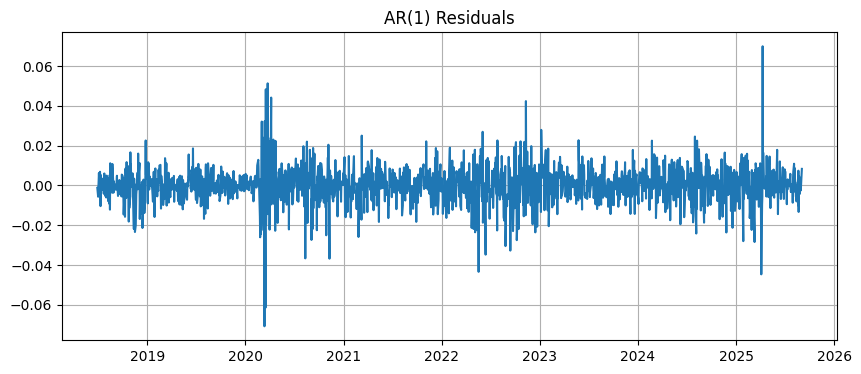

In [99]:
model_ar = AutoReg(log_returns, lags=1)
res_ar = model_ar.fit()
print(res_ar.summary())

# Plot residuals
resid = res_ar.resid
plt.figure(figsize=(10,4))
plt.plot(resid)
plt.title("AR(1) Residuals"); plt.grid(True)
plt.show()

## From AR(1) to ARMA and ARIMA Models  

Our AR(1) model gave a first look at short-term predictability in portfolio returns.  
But the residual diagnostics showed that the model was **missing structure** — the residuals did not look like pure white noise.  

This suggests that returns may depend on **more than one lag** and could also reflect the effect of past shocks.  

That’s where the **ARMA(p,q)** model comes in:  

$$
r_t = c + \sum_{i=1}^p \phi_i r_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j} + \epsilon_t
$$

- **AR(p):** captures dependence on past returns (momentum or mean-reversion).  
- **MA(q):** captures dependence on past shocks or news.  

If the data are non-stationary, we extend to **ARIMA(p,d,q)**, where differencing the series \(d\) times ensures stationarity.  

$$
\text{ARIMA}(p,d,q) \quad \Rightarrow \quad \text{ARMA}(p,q) \text{ on the differenced series}
$$

In short:  
- AR(1) was too simple.  
- ARMA/ARIMA lets us capture **both persistence and shocks**, giving a richer and more realistic model for returns.  


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1804
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5886.260
Date:                Wed, 03 Sep 2025   AIC                         -11764.520
Time:                        01:20:52   BIC                         -11742.529
Sample:                             0   HQIC                        -11756.404
                               - 1804                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      3.876      0.000       0.000       0.001
ar.L1         -0.9503      0.031    -30.690      0.000      -1.011      -0.890
ma.L1          0.9061      0.034     26.946      0.0

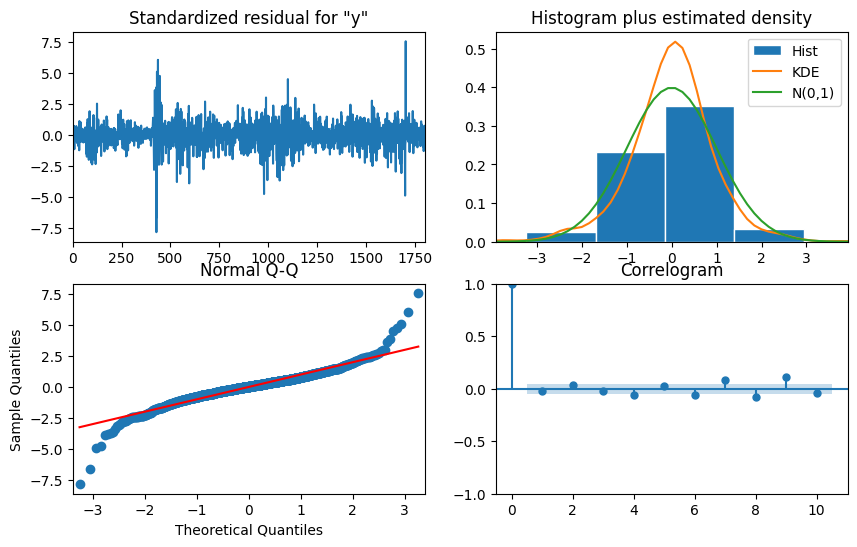

In [113]:
model_arima = ARIMA(log_returns, order=(1,0,1))  # ARMA(1,1)
res_arima = model_arima.fit()
print(res_arima.summary())
res_arima.plot_diagnostics(figsize=(10,6))
plt.show()

---

## 🔥 From ARIMA to GARCH: Modeling Volatility

Our ARIMA(1,0,1) model improved on the simple AR(1) by capturing both **persistence** in returns (AR) and **shock effects** (MA).  
The correlogram showed no leftover autocorrelation, which means ARIMA explained most of the **linear structure** in returns.  

But looking at the residual diagnostics, two issues remain:

- **Fat tails:** Extreme outcomes are more common than a Normal distribution predicts.  
- **Volatility clustering:** Periods of calm are followed by periods of turbulence, which ARIMA does not model directly.  

This means that while ARIMA is a strong **mean model**, it doesn’t fully explain the **variance dynamics** — the changing volatility that is a hallmark of financial data.

To capture these features, we now turn to **GARCH (Generalized Autoregressive Conditional Heteroskedasticity)** models.  


We model returns as:

$$
r_t = \mu + \epsilon_t, \quad \epsilon_t = \sigma_t z_t, \quad z_t \sim \text{i.i.d. } \mathcal{N} (0,1)
$$

where:
- $r_t$ = return at time $t$  
- $\mu$ = mean (drift) of returns  
- $\epsilon_t$ = innovation (shock) at time $t$  
- $\sigma_t$ = conditional volatility  
- $z_t$ = standardized noise (usually Normal or Student-$t$)  

---

### Volatility Dynamics

The conditional variance evolves as:

$$
\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2
$$

where:
- $\omega > 0$: long-run baseline variance  
- $\alpha_1 \geq 0$: reaction to new shocks (yesterday’s squared return)  
- $\beta_1 \geq 0$: persistence of volatility (yesterday’s variance)  

---

- GARCH explicitly models volatility as a predictable, time-varying process.  
- This allows us to measure and forecast **conditional variance**, not just returns.  
- In practice, this gives us more realistic risk estimates (VaR, ES) that account for clustering and fat tails.

Next, we’ll fit a **GARCH(1,1)** model to the ARIMA residuals to see whether we can model the volatility directly.

---

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.473e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6117.33
Distribution:                  Normal   AIC:                          -12226.7
Method:            Maximum Likelihood   BIC:                          -12204.7
                                        No. Observations:                 1804
Date:                Wed, Sep 03 2025   Df Residuals:                     1803
Time:                        01:24:31   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.8787e-04  1.766e-04      5.026  4.996e-07 [5.

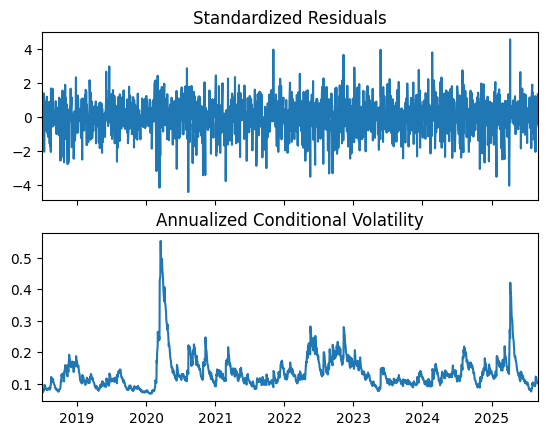

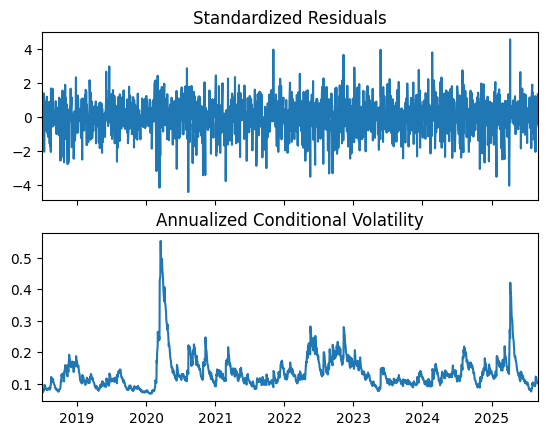

In [115]:
model_garch = arch_model(log_returns, vol="GARCH", p=1, q=1)
res_garch = model_garch.fit(disp="off")
print(res_garch.summary())
res_garch.plot(annualize="D")

GARCH(1,1) Volatility and Risk Forecast


,Day Ahead,Volatility (σ),VaR 95%,ES 95%
0,1,0.007,-0.010,-0.013
1,2,0.007,-0.010,-0.013
2,3,0.007,-0.010,-0.013
3,4,0.007,-0.010,-0.013
4,5,0.007,-0.010,-0.013
5,6,0.007,-0.011,-0.013
6,7,0.007,-0.011,-0.014
7,8,0.007,-0.011,-0.014
8,9,0.007,-0.011,-0.014
9,10,0.007,-0.011,-0.014


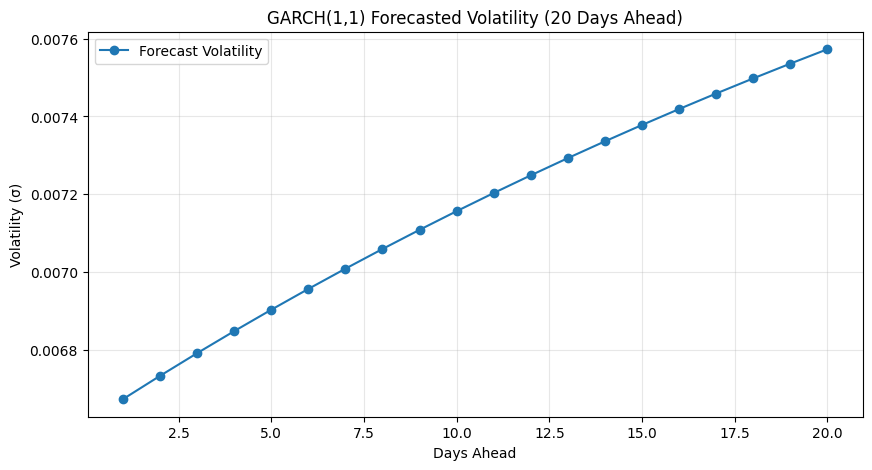

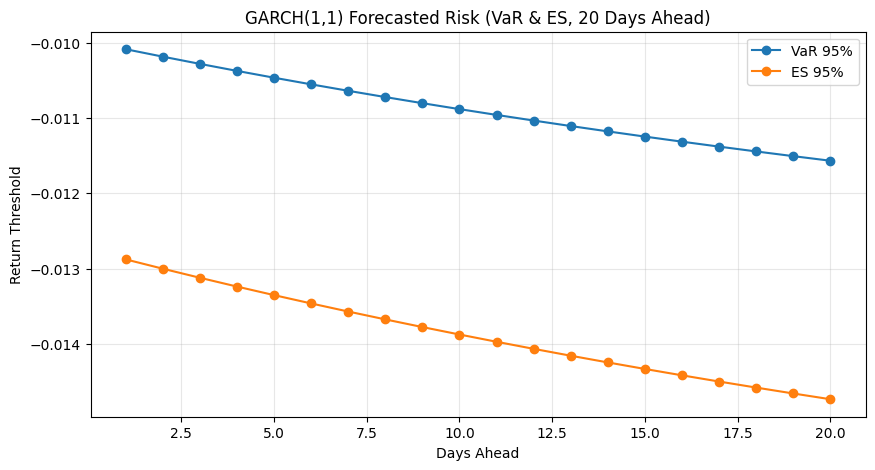

In [118]:
# --- Forecasting volatility and risk with GARCH(1,1) ---

# Forecast 20 days ahead
horizon = 20
garch_forecast = res_garch.forecast(horizon=horizon)

# Extract conditional variances and convert to volatility
var_forecast = garch_forecast.variance.values[-1, :]
vol_forecast = np.sqrt(var_forecast)

# --- Use scalar mean from GARCH model ---
mu_hat = res_garch.params["mu"]   # scalar mean, not the whole series

# Daily VaR & ES at 95% confidence
alpha = 0.05
z_alpha = norm.ppf(alpha)   # quantile
phi_alpha = norm.pdf(z_alpha)

VaR_95 = mu_hat + vol_forecast * z_alpha
ES_95  = mu_hat - vol_forecast * (phi_alpha / alpha)

# Assemble into DataFrame
df_forecast = pd.DataFrame({
    "Day Ahead": np.arange(1, horizon+1),
    "Volatility (σ)": vol_forecast,
    "VaR 95%": VaR_95,
    "ES 95%": ES_95
})

print("GARCH(1,1) Volatility and Risk Forecast")
display(df_forecast)

# Plot volatility forecast
plt.figure(figsize=(10,5))
plt.plot(df_forecast["Day Ahead"], df_forecast["Volatility (σ)"], marker="o", label="Forecast Volatility")
plt.title("GARCH(1,1) Forecasted Volatility (20 Days Ahead)")
plt.xlabel("Days Ahead")
plt.ylabel("Volatility (σ)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot VaR and ES forecasts
plt.figure(figsize=(10,5))
plt.plot(df_forecast["Day Ahead"], df_forecast["VaR 95%"], marker="o", label="VaR 95%")
plt.plot(df_forecast["Day Ahead"], df_forecast["ES 95%"], marker="o", label="ES 95%")
plt.title("GARCH(1,1) Forecasted Risk (VaR & ES, 20 Days Ahead)")
plt.xlabel("Days Ahead")
plt.ylabel("Return Threshold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# 🔚 Conclusion: Risk is Dynamic

Up to this point we’ve seen that:

- **Fat tails & bootstrapping**: Losses can be worse than expected, and even our *estimates of risk* carry uncertainty.  
- **Diversification & MPT**: Portfolios can be structured to balance risk and return — risk is not just about single assets.  
- **AR/ARIMA models**: Returns may contain structure, but residuals reveal that markets are often closer to noise than signal.  
- **GARCH models**: Volatility itself is *time-varying* and clusters — risk is not constant but evolves dynamically.

---

### Key Takeaway  
Risk is not static:  
- It comes from **tails** (extremes),  
- From **cross-sections** (portfolio allocation), and  
- From **time** (volatility dynamics).  

Tools like VaR, ES, MPT, ARIMA, and GARCH provide complementary lenses. Together, they help us better **measure, forecast, and manage financial risk**.

---
